In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp /content/drive/'My Drive'/kaggle.json .
!cp /content/drive/'My Drive'/tweeter/utils_for_ml.py .

In [0]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle

In [4]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 63.4MB/s]
  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 23.4MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 172MB/s]


In [5]:
!pip install vaderSentiment


     |████████████████████████████████| 133kB 2.8MB/s 


In [0]:
import pandas as pd
import numpy as np

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
import seaborn as sns

from utils_for_ml import *

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [8]:
train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


##Extracting features:

In the next cells I will use Vader library to analyze each tweet:

In [0]:
analyzer = SentimentIntensityAnalyzer()

train_list = []
for sentiment in train['text']:
    sentiments = analyzer.polarity_scores(sentiment)
    list_temp=[]
    for key, value in sentiments.items():
        temp = value
        list_temp.append(temp)
    train_list.append(list_temp)

test_list = []
for sentiment in test['text']:
    sentiments = analyzer.polarity_scores(sentiment)
    list_temp=[]
    for key, value in sentiments.items():
        temp = value
        list_temp.append(temp)
    test_list.append(list_temp)

Adding corresponding columns to datasets:

In [10]:
temp_train = pd.DataFrame(train_list, columns=['compound','neg','neu','pos'], index=train.index)
train = pd.merge(train, temp_train, left_index=True,right_index=True)

temp_test = pd.DataFrame(test_list, columns=['compound','neg','neu','pos'], index=test.index)
test = pd.merge(test, temp_test, left_index=True,right_index=True)

train.head()

,id,keyword,location,text,target,compound,neg,neu,pos
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.000,0.851,0.149,0.2732
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0.286,0.714,0.000,-0.3400
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0.095,0.905,0.000,-0.2960
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0.000,1.000,0.000,0.0000
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0.000,1.000,0.000,0.0000


Dropping unnecessary columns:

In [0]:
train = train.drop(columns=['keyword', 'location', 'text'])
test = test.drop(columns=['keyword', 'location', 'text'])

##Data Analysis:

I expect to get some dependence of new columns with the target, let's build a correlation plot to see this:

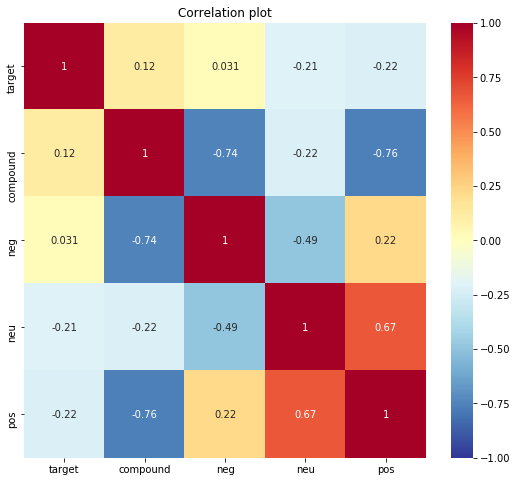

In [12]:
plt.figure(figsize = (9, 8))

sns.heatmap(train.drop(columns=['id']).corr(), cmap = plt.cm.RdYlBu_r, vmin = -1.0, annot = True, vmax = 1.0)
plt.title('Correlation plot')
plt.show()

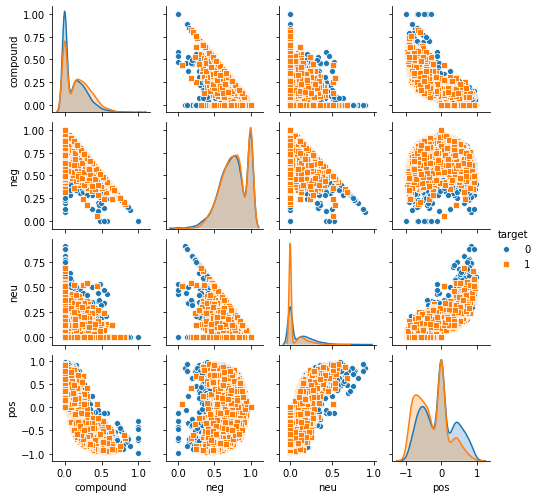

In [13]:
sns.pairplot(train.drop(columns=['id']), hue='target', markers=["o", "s"], height = 1.7)
plt.show()

Hmm, not really that I wanted to get. We can see just a strong correlation between 'pos' and 'neg' columns and 'pos' and 'compound' columns. Also distributions for real and fake tweets are almost the same for each feature... But let's try to add these features to the model:

##Model:

In [0]:
labels = train['target']

features = np.array(train.drop(columns = ['id', 'target']))
test_features = np.array(test.drop(columns = ['id']))

As I didn't get linear dependence between each column with the target column, I will use the tree-based model:

In [21]:
train_prediction = cross_val(features,
                             labels,
                             model_type = 'forest',
                             n_estimators = 100,
                             print_feature_importances = True,
                             n_folds = 5)

Training Data Shape:  (7613, 4)

Feature importances:

[0.20220326 0.25122134 0.17357289 0.37300251]
[0.20760131 0.2518966  0.16941329 0.3710888 ]
[0.20526885 0.25054464 0.17160943 0.37257708]
[0.20298645 0.24722324 0.17652875 0.37326156]
[0.20629369 0.25070632 0.17034871 0.37265129]

F1 Score: 0.47622504537205085


We can make conclusion, that the most important feature is 'positive' column.

In [0]:
prediction = train.copy()

prediction['vader_pred'] = train_prediction
prediction = prediction.drop(columns = ['compound', 'neg', 'neu', 'pos'])

In [23]:
prediction.head()

,id,target,vader_pred
0,1,1,0.269286
1,4,1,0.518183
2,5,1,0.176571
3,6,1,0.440380
4,7,1,0.434656


And test prediction fitting on all dataset:

In [0]:
model = RandomForestClassifier(n_estimators=100, criterion = 'entropy', max_features = None, n_jobs = -1)

model.fit(features, labels)

test_prediction = model.predict_proba(test_features)

In [0]:
test_predictions = test.copy()

test_predictions['vader_pred'] = test_prediction[:, 1]

test_predictions = test_predictions.drop(columns = ['compound', 'neg', 'neu', 'pos'])

In [26]:
test_predictions.head()

,id,vader_pred
0,0,0.010000
1,2,0.000000
2,3,0.887186
3,9,0.437566
4,11,0.230048


In [0]:
prediction.to_csv('/content/drive/My Drive/tweeter/train_predictions_vader.csv', index_label='idx')
test_predictions.to_csv('/content/drive/My Drive/tweeter/test_predictions_vader.csv', index_label='idx')